# Fast Food Nutrition Clustering



In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (8, 4)
sns.set(style="whitegrid")


In [ ]:
csv_path = "Nutrition_Value_Dataset.csv"

df = pd.read_csv(csv_path)
print(df.shape)
df.head()


(530, 14)


,Company,Category,Product,Per Serve Size,Energy (kCal),Carbohydrates (g),Protein (g),Fiber (g),Sugar (g),Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg)
0,Pizza Hut,All Meals,Corn n Cheese (Personal),143.5 g,432.60,65.64,17.91,3.85,0.0,10.93,5.14,0.16,16.19,499.72
1,Pizza Hut,All Meals,Country Feast (Personal),178 g,407.60,67.11,16.73,7.19,0.0,8.03,3.24,0.11,66.80,818.00
2,Pizza Hut,All Meals,Double Cheese (Personal),143 g,423.33,59.97,18.26,3.49,0.0,12.27,5.23,0.18,19.75,638.22
3,Pizza Hut,All Meals,Double Paneer Supreme (Personal),174.5 g,474.03,52.86,20.07,3.79,0.0,20.26,9.25,0.33,71.72,1128.11
4,Pizza Hut,All Meals,Farmer`s Pick (Personal),177 g,408.16,53.93,19.91,2.46,0.0,12.53,4.90,0.14,48.09,942.67


In [ ]:
features = [
    "Energy (kCal)",
    "Carbohydrates (g)",
    "Protein (g)",
    "Fiber (g)",
    "Sugar (g)",
    "Total Fat (g)",
    "Saturated Fat (g)",
    "Trans Fat (g)",
    "Cholesterol (mg)",
    "Sodium (mg)"
]

import numpy as np

data = df[features].copy()

data = data.replace([np.inf, -np.inf], np.nan)

data_clean = data.dropna()

print("Original rows:", data.shape[0])
print("Rows after dropping NA / inf:", data_clean.shape[0])

print(data_clean.describe().T)


Original rows: 530
Rows after dropping NA / inf: 435
                   count        mean         std  min      25%     50%  \
Energy (kCal)      435.0  400.890044  358.177055  0.0  199.720  365.21   
Carbohydrates (g)  435.0   40.769241   21.290729  0.0   25.680   41.54   
Protein (g)        435.0   17.284552   25.579136  0.0    4.000   12.40   
Fiber (g)          435.0    4.796690    6.082692  0.0    1.000    3.00   
Sugar (g)          435.0    9.203218   13.179848  0.0    0.000    2.73   
Total Fat (g)      435.0   14.323264   10.610188  0.0    7.005   14.00   
Saturated Fat (g)  435.0    6.378713    4.920084  0.0    3.240    6.06   
Trans Fat (g)      435.0    0.312793    3.604137  0.0    0.020    0.12   
Cholesterol (mg)   435.0   50.483747  110.350605  0.0    6.020   23.00   
Sodium (mg)        435.0  430.167331  472.119478  0.0    1.600  250.00   

                       75%      max  
Energy (kCal)      475.750  2880.00  
Carbohydrates (g)   56.220   100.60  
Protein (g)       

In [25]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data_clean)

print("Scaled shape:", scaled.shape)


Scaled shape: (435, 10)


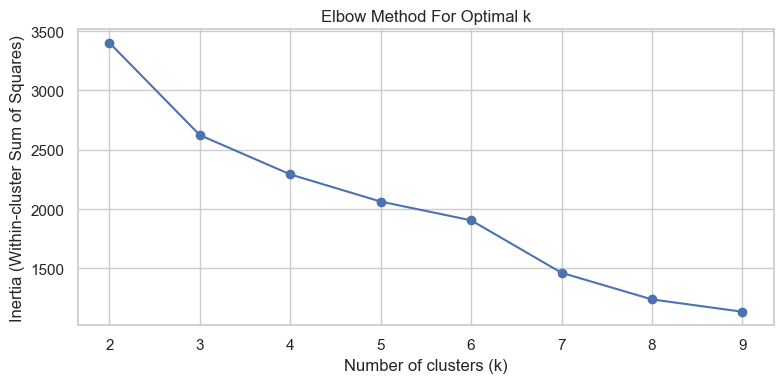

In [26]:
inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.xticks(list(K))
plt.tight_layout()
plt.show()


In [27]:
sil_scores = {}

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(scaled)
    sil = silhouette_score(scaled, labels)
    sil_scores[k] = sil

sil_scores


{2: 0.513242368230817,
 3: 0.3025715248719668,
 4: 0.32017318629297037,
 5: 0.2721564245277927,
 6: 0.25305737319107224,
 7: 0.2627863216891861,
 8: 0.2683207845700649,
 9: 0.27050070534296256}

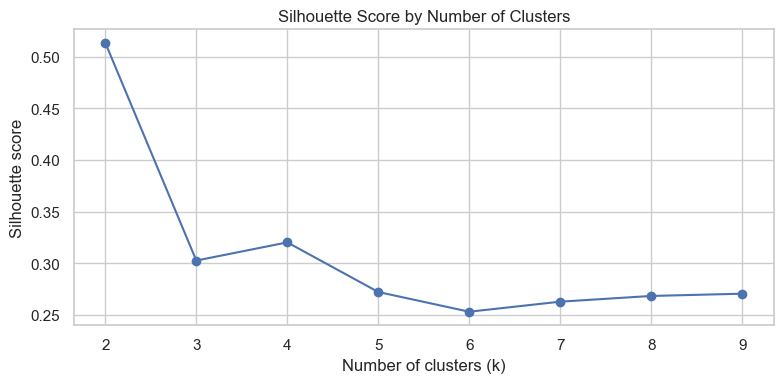

In [28]:
plt.figure()
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.xticks(list(K))
plt.tight_layout()
plt.show()


In [ ]:
best_k = 4  

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(scaled)

df_clustered = df.loc[data_clean.index].copy()
df_clustered["Cluster"] = cluster_labels

df_clustered[["Company", "Category", "Product", "Cluster"]].head()


,Company,Category,Product,Cluster
0,Pizza Hut,All Meals,Corn n Cheese (Personal),2
1,Pizza Hut,All Meals,Country Feast (Personal),2
2,Pizza Hut,All Meals,Double Cheese (Personal),2
3,Pizza Hut,All Meals,Double Paneer Supreme (Personal),2
4,Pizza Hut,All Meals,Farmer`s Pick (Personal),2


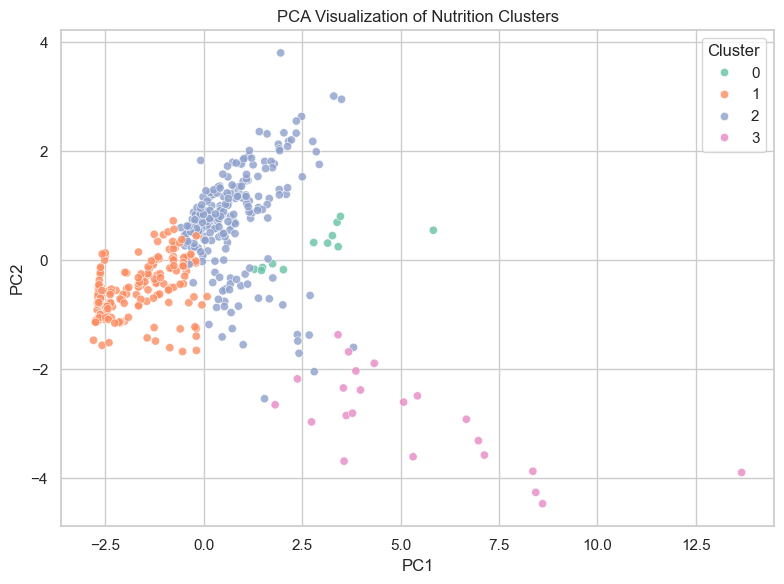

In [30]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

pca_df = pd.DataFrame({
    "PC1": components[:, 0],
    "PC2": components[:, 1],
    "Cluster": cluster_labels
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="Set2",
    alpha=0.8
)
plt.title("PCA Visualization of Nutrition Clusters")
plt.tight_layout()
plt.show()


In [31]:
cluster_summary = df_clustered.groupby("Cluster")[features].mean().round(2)
cluster_summary


,Energy (kCal),Carbohydrates (g),Protein (g),Fiber (g),Sugar (g),Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg)
Cluster,,,,,,,,,,
0,585.45,69.55,20.65,8.08,8.75,26.80,15.06,0.00,557.67,1.37
1,181.74,25.38,4.78,1.72,16.63,6.38,3.25,0.11,17.75,150.37
2,463.44,53.20,18.45,5.81,3.49,18.44,7.87,0.54,51.11,748.45
3,1580.15,37.48,111.68,19.64,0.74,36.10,14.12,0.07,49.09,0.73


In [32]:
example_items = df_clustered[["Company", "Category", "Product", "Cluster"]]    .sort_values("Cluster")    .groupby("Cluster")    .head(5)

example_items


,Company,Category,Product,Cluster
183,Burger King,All Meals,Cheesy Italian fries,0
147,Burger King,All Meals,Paneer king,0
150,Burger King,All Meals,Veg Whopper,0
151,Burger King,All Meals,Masala Whopper Veg,0
157,Burger King,All Meals,Xtra Long chicken,0
282,McDonalds,McCAFE MENU,Cappuccino (L),1
281,McDonalds,McCAFE MENU,Cappuccino (R),1
280,McDonalds,McCAFE MENU,Cappuccino (S),1
279,McDonalds,McCAFE MENU,Americano (L),1
278,McDonalds,McCAFE MENU,Americano (R),1
